# Memory Context Engineering for AI Agents

This notebook demonstrates how to design and optimize an agentic AI system with memory context engineering for healthcare assistance.  

The agent integrates reasoning, external tool usage, and context management to provide reliable, structured, and cost-efficient responses.


![](https://i.imgur.com/HRNXG4b.png)

Key aspects covered:
- **System Design**: Define a health assistant agent that can answer medical queries, research healthcare information, and recommend doctors from a structured database.
- **Tool Integration**: Implement two tools, one for searching the web for medical information and another for recommending appropriate doctors.
- **Graph Architecture**: Use LangGraph to connect the agent, tools, and memory, enabling structured reasoning and decision-making loops.
- **Memory Management**: Employ a checkpointer to persist session context across multiple queries, ensuring continuity in user conversations.
- **Context Optimization**: Introduce message trimming and tool output summarization to control context length, reduce costs, and improve efficiency in long-running interactions.
- **Practical Testing**: Run the agent on multiple sample queries to demonstrate multi-turn dialogue, contextual awareness, and optimized reasoning.

The overall goal is to showcase how memory context engineering techniques can make AI agents more scalable, cost-effective, and reliable in real-world use cases.


## Install Dependencies

In [ ]:
!pip install langchain==0.3.27 langchain-community==0.3.27 langchain-openai==0.3.30 langgraph==0.6.5 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 12.0 MB/s eta 0:00:00


## Setup API Keys and Environment

Here we enter our API keys for OpenAI and Tavily Search and set them in our environment

In [ ]:
import os
import getpass

# OpenAI API Key (for chat & embeddings)
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key (https://platform.openai.com/account/api-keys):\n")

# Tavily API Key (for web search)
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key (https://app.tavily.com/home):\n")

Enter your OpenAI API key (https://platform.openai.com/account/api-keys):
··········
Enter your Tavily API key (https://app.tavily.com/home):
··········


## Build a Health Assistant Agentic AI System with Memory

In this section, we design and implement a health-focused agentic AI system that leverages reasoning, memory, and tool integration.  
The goal is to create an AI assistant that can research medical symptoms, provide healthcare guidance, and recommend appropriate doctors.  

Key components introduced here:
- **System Prompt**: Defines the behavior of the agent, guiding how it responds to different user queries (e.g., when to search vs. when to recommend a doctor).  
- **External Tools**: Connect the LLM to outside sources of information like the internet or a doctor database.  
- **Memory Integration**: Ensures that past user interactions are retained across multiple turns, allowing the assistant to give context-aware answers.  
- **Agent Graph**: Establishes how the agent flows between reasoning, tool usage, and response generation.  

This foundation sets up the core structure of the Health Assistant, enabling multi-turn conversations that combine external knowledge with contextual understanding.


### Build Tools

This part covers the creation of specialized tools that the agent can call when reasoning about user queries.  
- **Search Web Tool**: Retrieves relevant health information from the internet, ensuring results include detailed content and source links.  
- **Recommend Doctor Tool**: Selects appropriate doctors from a small in-memory database using the LLM, returning structured details such as specialization, availability, and contact information.  


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool
import requests


# Tavily Web Search
tavily_search = TavilySearchAPIWrapper()

@tool
def search_web_extract_info(query: str) -> list:
    """Search the web for a query. Useful for general information or general news."""
    results = tavily_search.raw_results(query=query, max_results=5, search_depth='advanced',
                                        include_answer=False, include_raw_content=True)
    docs = results['results']
    docs = [doc for doc in docs if doc.get("raw_content") is not None]
    docs = ['## Title\n'+doc['title']+'\n\n'+'## Content\n'+doc['raw_content']+'\n\n'+'##Source\n'+doc['url'] for doc in docs]
    return docs

In [ ]:
# doctor database
doctors_db = [
    {"name": "Dr. Janet Dyne", "specialization": "Endocrinology (Diabetes Care)", "available_timings": "10:00 AM - 1:00 PM", "location": "City Health Clinic", "contact": "janet.dyne@healthclinic.com"},
    {"name": "Dr. Don Blake ", "specialization": "Cardiology (Heart Specialist)", "available_timings": "2:00 PM - 5:00 PM", "location": "Metro Cardiac Center", "contact": "don.blake@metrocardiac.com"},
    {"name": "Dr. Susan D'Souza", "specialization": "Oncology (Cancer Care)", "available_timings": "11:00 AM - 2:00 PM", "location": "Hope Cancer Institute", "contact": "susan.dsouza@hopecancer.org"},
    {"name": "Dr. Matt Murdock", "specialization": "Psychiatry (Mental Health)", "available_timings": "4:00 PM - 7:00 PM", "location": "Mind Care Center", "contact": "matt.murdock@mindcare.com"},
    {"name": "Dr. Dinah Lance", "specialization": "General Physician", "available_timings": "9:00 AM - 12:00 PM", "location": "Downtown Medical Center", "contact": "dinah.lance@downtownmed.com"}
]

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

@tool
def recommend_doctor(query: str) -> dict:
    """Recommend the most suitable doctor based on the user's symptoms."""
    doctors_list = str(doctors_db)
    prompt = f"""
You are an assistant helping recommend a doctor based on patient's health issues.

Here is the list of available doctors:

{doctors_list}

Given the user's query: "{query}"

Choose the most suitable doctor from the list. Only pick one doctor.
Return only the selected doctor's information in JSON format.
If not sure, recommend the General Physician.
"""
    response = small_llm.invoke(prompt)
    return {"recommended_doctor": response.content}


### Define Agent Node Functions & Graph

Here the notebook defines how the agent workflow is orchestrated with LangGraph.  
- **Agent Node**: Uses the system prompt and LLM to decide whether to answer directly or invoke a tool.  
- **Tool Node**: Executes the requested tool and passes results back to the LLM.  
- **Graph**: Establishes routes between the agent, tools, and end state, while also attaching memory to persist dialogue context across multiple queries.  

In [ ]:
tools = [search_web_extract_info, recommend_doctor]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
from langchain_core.messages import SystemMessage

AGENT_PROMPT_TXT = """You are an agent designed to act as an expert in researching on medical symptoms
and also recommend relevant doctors for booking appointments. The current year is 2025.

Given an input user query call relevant tools and give the most appropriate response.
Follow some of these guidelines to help you make more informed decisions:
  - If the user's query specifies recommending a doctor only then recommend an appropriate doctor
  - If the user is researching on aspects around healthcare use web search
  - Response should include cited source links, Publication Dates if available
  - If recommending doctors then show detailed information in a nice structured way and recommend them to book an appointment via email
"""

AGENT_SYS_PROMPT = SystemMessage(content=AGENT_PROMPT_TXT)

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# create agent state schema
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the node function that handles reasoning and planning using the LLM
def tool_calling_llm(state: State) -> State:
    # get agent state and then get next step (response) from llm
    current_state = state["messages"]
    state_with_instructions = [AGENT_SYS_PROMPT] + current_state
    response = [llm_with_tools.invoke(state_with_instructions)]

    token_usage = response[0].usage_metadata
    print('-'*25, 'TOKEN USAGE', '-'*25)
    print("Token count (input context):", token_usage['input_tokens'])
    print("Token count (response):", token_usage['output_tokens'])
    print('-'*25, 'TOKEN USAGE', '-'*25)

    # Return the updated state containing the new message
    return {"messages": response}

# create node function for tools
tool_node = ToolNode(tools=tools)


# Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", tool_node)

# Add edges
builder.add_edge(START, "tool_calling_llm")
# Conditional edge
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition, # conditional routing function
    ["tools", END]
)
builder.add_edge("tools", "tool_calling_llm") # this is the key feedback loop in the agentic system

# Compile Agent Graph with memory
memory = MemorySaver() # Add in-memory store - can change to in-memory databases also
agent = builder.compile(checkpointer=memory)

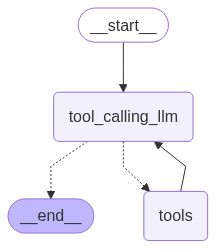

In [ ]:
agent

### Test Agent on Sample Queries

In [ ]:
!gdown 1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB

Downloading...
From (original): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB
From (redirected): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB&confirm=t&uuid=a425770d-1bdc-49b9-9126-a993fd37e466
To: /content/agent_utils.py
100% 6.38k/6.38k [00:00<00:00, 17.6MB/s]


In [ ]:
from IPython.display import display, Markdown
from agent_utils import format_message

# Utility function to call the agent and stream its step-by-step reasoning for a specific user
def call_conversational_agent(agent, prompt, user_session_id, verbose=False):
    # Stream the agent's execution using the given prompt and session ID for memory tracking
    events = agent.stream(
        {"messages": [{"role": "user", "content": prompt}]},   # User input prompt
        {"configurable": {"thread_id": user_session_id}},      # Thread ID for session-based memory (multi-user support)
        stream_mode="values"                                   # Stream messages as the agent processes them
    )

    print('Running Agent. Please wait...')

    # Iterate through each step of the streamed agent output
    for event in events:
        # If verbose mode is enabled, print each intermediate message
        if verbose:
            format_message(event["messages"][-1])

    # Display the final response from the agent as formatted Markdown
    print('\n\nAgent Final Response:\n')
    display(Markdown(event["messages"][-1].content))
    return event['messages']

In [ ]:
uid = 'john001'
query = "Tell me latest and best methods for diabetes management"
output = call_conversational_agent(agent, query, uid, verbose=True)

Running Agent. Please wait...


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Tell me latest and best methods for diabetes management                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

------------------------- TOKEN USAGE -------------------------
Token count (input context): 220
Token count (response): 23
------------------------- TOKEN USAGE -------------------------


╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: search_web_extract_info                                                                           │
│    Args: {                                                                                                      │
│   "query": "latest methods for diabetes management 2025"                                                        │
│ }                                                                                                               │
│    ID: call_vqZOPx0PErFykPcU2ptx3lP9                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["## Title\nChanges to the Standards of Care in Diabetes—2025 - Blog\n\n## Content\nChanges to the Standards of │
│ Care in Diabetes—2025 - Blog - NIDDK\n\n===============\n\n[Skip to main                                        │
│ content](https://www.niddk.nih.gov/health-information/professionals/diabetes-discoveries-practice/changes-stand │
│ ards-care-diabetes2025#main)\n\nDue to current HHS and NIH restructuring, the information provided on           │
│ niddk.nih.gov is not being updated. Please refer to (https://www.nih.gov/).\n\n![Image 1: U.S.                  │
│ flag](blob:http://localhost/28ac974dcc54f856173f0c3376bc989e)\n\nAn official website of the United States       │
│ government\n\nHere’s how you know\n\nHere’s how you know\n\n**Official websites use .gov**\n\n A **.gov**       │
│ website belongs to an official government organization in the United States.\n\n**Secure .gov websites use      │
│ HTTPS**\n\n A **lock** (  ) or **https://** means you’ve safely connected to the .gov website. Share sensitive  │
│ information only on official, secure websites.\n\n[![Image 2: NIH: National Institute of Diabetes and Digestive │
│ and Kidney Diseases](https://www.niddk.nih.gov/_ux/niddk/9.40.0/images/site-logos.svg#full)![Image 3: NIH:      │
│ National Institute of Diabetes and Digestive and Kidney                                                         │
│ Diseases](https://www.niddk.nih.gov/_ux/niddk/9.40.0/images/site-logos.svg#abbrev)](https://www.niddk.nih.gov/  │
│ \"NIDDK home page\")[![Image 4: 75 years:                                                                       │
│ 1950-2025](https://www.niddk.nih.gov/_ux/niddk/9.40.0/images/site-logos.svg#full75)![Image 5: 75 years:         │
│ 1950-2025](https://www.niddk.nih.gov/_ux/niddk/9.40.0/images/site-logos.svg#abbrev75)](https://www.niddk.nih.go │
│ v/about-niddk/75th-anniversary \"NIDDK 75th Anniversary\")\n\nSearch Menu\n\nSearch for Information from        │
│ NIDDK\n\n*   Entire Site\n*   Research & Funding\n*   Health Information\n*   News\n*   About                   │
│ NIDDK\n\nSearch\n\n[Home](https://www.niddk.nih.gov/)\n\n-  \n\n[Research &                                     │
│ Funding](https://www.niddk.nih.gov/research-funding)Expand Research & Funding \n\n[Current Funding              │
│ Opportunities](https://www.niddk.nih.gov/research-funding/current-opportunities)\n\n[Research Programs &        │
│ Contacts](https://www.niddk.nih.gov/research-funding/research-programs)\n\n[Human Subjects                      │
│ Research](https://www.niddk.nih.gov/research-funding/human-subjects-research)\n\n[Funding                       │
│ Process](https://www.niddk.nih.gov/research-funding/process)\n\n[Research Training & Career                     │
│ Development](https://www.niddk.nih.gov/research-funding/training-career-development)\n\n[Funded Grants & Grant  │
│ History](https://www.niddk.nih.gov/research-funding/funded-grants-grant-history)\n\n[Research                   │
│ Resources](https://www.niddk.nih.gov/research-funding/research-resources)\n\n[Research at                       │
│ NIDDK](https://www.niddk.nih.gov/research-funding/at-niddk)\n\n[Technology Advancement &                        │
│ Transfer](https://www.niddk.nih.gov/research-funding/technology-advancement-transfer)\n\n[Meetings &            │
│ Workshops](https://www.niddk.nih.gov/news/meetings-workshops)\n\n-  \n\n[Health                                 │
│ Information](https://www.niddk.nih.gov/health-information)Expand Health Information \n\nHealth                  │
│ Topics\n\n[Diabetes](https://www.niddk.nih.gov/health-information/diabetes)\n\n[Digestive                       │
│ Diseases](https://www.niddk.nih.gov/health-information/digestive-diseases)\n\n[Kidney                           │
│ Disease](https://www.niddk.nih.gov/health-information/k

------------------------- TOKEN USAGE -------------------------
Token count (input context): 54379
Token count (response): 554
------------------------- TOKEN USAGE -------------------------


╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ The latest methods for diabetes management, as outlined in the **2025 Standards of Care in Diabetes** by the    │
│ American Diabetes Association (ADA), include several key updates and recommendations aimed at improving patient │
│ outcomes. Here are some of the most notable advancements:                                                       │
│                                                                                                                 │
│ ### Key Updates in Diabetes Management (2025)                                                                   │
│                                                                                                                 │
│ 1. **Medication Recommendations**:                                                                              │
│    - **GLP-1 Receptor Agonists**: Recommended for individuals with type 2 diabetes and chronic kidney disease   │
│ to reduce the risk of heart disease and protect kidney function.                                                │
│    - **Dual GIP and GLP-1 Receptor Agonists**: Suggested for those with type 2 diabetes, obesity, and heart     │
│ failure to manage glucose levels and alleviate heart failure symptoms.                                          │
│                                                                                                                 │
│ 2. **Nutrition and Lifestyle**:                                                                                 │
│    - Emphasis on **evidence-based healthy eating patterns**, including plant-based proteins and fiber, while    │
│ limiting saturated fats and sugary beverages.                                                                   │
│    - Recommendations for weight loss strategies, particularly for those with type 2 diabetes and nonalcoholic   │
│ fatty liver disease (NAFLD).                                                                                    │
│                                                                                                                 │
│ 3. **Technology Integration**:                                                                                  │
│    - Increased guidance on incorporating diabetes technology, such as continuous glucose monitoring (CGM), into │
│ treatment plans to enhance management and monitoring of diabetes.                                               │
│                                                                                                                 │
│ 4. **Screening and Diagnosis**:                                                                                 │
│    - Introduction of **antibody-based testing** for individuals at risk of developing type 1 diabetes,          │
│ particularly those with a family history.                                                                       │
│    - Updated screening protocols for various comorbidities, including cardiovascular disease and kidney health. │
│                                                                                                                 │
│ 5. **Psychosocial Considerations**:                                                                             │
│    - Routine screening for diabetes distress, depression, and anxiety, emphasizing the importance of mental     │
│ health in diabetes management.                                                                                  │
│                                                                                                                 │
│ 6. **Special Populations**:                                                                                     │
│    - Tailored recommendations for older adults and children, focusing on individualized care and the unique     │
│ challenges faced by these groups.                      



Agent Final Response:



The latest methods for diabetes management, as outlined in the **2025 Standards of Care in Diabetes** by the American Diabetes Association (ADA), include several key updates and recommendations aimed at improving patient outcomes. Here are some of the most notable advancements:

### Key Updates in Diabetes Management (2025)

1. **Medication Recommendations**:
   - **GLP-1 Receptor Agonists**: Recommended for individuals with type 2 diabetes and chronic kidney disease to reduce the risk of heart disease and protect kidney function.
   - **Dual GIP and GLP-1 Receptor Agonists**: Suggested for those with type 2 diabetes, obesity, and heart failure to manage glucose levels and alleviate heart failure symptoms.

2. **Nutrition and Lifestyle**:
   - Emphasis on **evidence-based healthy eating patterns**, including plant-based proteins and fiber, while limiting saturated fats and sugary beverages.
   - Recommendations for weight loss strategies, particularly for those with type 2 diabetes and nonalcoholic fatty liver disease (NAFLD).

3. **Technology Integration**:
   - Increased guidance on incorporating diabetes technology, such as continuous glucose monitoring (CGM), into treatment plans to enhance management and monitoring of diabetes.

4. **Screening and Diagnosis**:
   - Introduction of **antibody-based testing** for individuals at risk of developing type 1 diabetes, particularly those with a family history.
   - Updated screening protocols for various comorbidities, including cardiovascular disease and kidney health.

5. **Psychosocial Considerations**:
   - Routine screening for diabetes distress, depression, and anxiety, emphasizing the importance of mental health in diabetes management.

6. **Special Populations**:
   - Tailored recommendations for older adults and children, focusing on individualized care and the unique challenges faced by these groups.

7. **Comprehensive Care Approach**:
   - Encouragement of a **team-based care model** that includes various healthcare professionals to address the multifaceted needs of individuals with diabetes.

### Resources for Further Information
- For a detailed overview of the 2025 Standards of Care, you can access the full document [here](https://diabetesjournals.org/care/issue/48/Supplement_1) (ADA, January 2025).
- Additional insights and updates can be found in the [Summary of Revisions](https://diabetesjournals.org/care/article/48/Supplement_1/S6/157564/Summary-of-Revisions-Standards-of-Care-in-Diabetes) (ADA, December 2024).

These updates reflect a growing understanding of diabetes management that prioritizes personalized care, the integration of technology, and a holistic approach to health and well-being.

In [ ]:
query = "Please recommend a right doctor"
output = call_conversational_agent(agent, query, uid, verbose=True)

Running Agent. Please wait...


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Please recommend a right doctor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

------------------------- TOKEN USAGE -------------------------
Token count (input context): 54945
Token count (response): 18
------------------------- TOKEN USAGE -------------------------


╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: recommend_doctor                                                                                  │
│    Args: {                                                                                                      │
│   "query": "diabetes management"                                                                                │
│ }                                                                                                               │
│    ID: call_SCjPBRhckmYOtkFJ2Zrs1k6P                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"recommended_doctor": "```json\n{\n    \"name\": \"Dr. Janet Dyne\",\n    \"specialization\": \"Endocrinology  │
│ (Diabetes Care)\",\n    \"available_timings\": \"10:00 AM - 1:00 PM\",\n    \"location\": \"City Health         │
│ Clinic\",\n    \"contact\": \"janet.dyne@healthclinic.com\"\n}\n```"}                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

------------------------- TOKEN USAGE -------------------------
Token count (input context): 55061
Token count (response): 101
------------------------- TOKEN USAGE -------------------------


╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ I recommend the following doctor for diabetes management:                                                       │
│                                                                                                                 │
│ ### Dr. Janet Dyne                                                                                              │
│ - **Specialization**: Endocrinology (Diabetes Care)                                                             │
│ - **Available Timings**: 10:00 AM - 1:00 PM                                                                     │
│ - **Location**: City Health Clinic                                                                              │
│ - **Contact**: (mailto:janet.dyne@healthclinic.com)                                                             │
│                                                                                                                 │
│ You can book an appointment with Dr. Dyne by emailing her directly.                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯



Agent Final Response:



I recommend the following doctor for diabetes management:

### Dr. Janet Dyne
- **Specialization**: Endocrinology (Diabetes Care)
- **Available Timings**: 10:00 AM - 1:00 PM
- **Location**: City Health Clinic
- **Contact**: [janet.dyne@healthclinic.com](mailto:janet.dyne@healthclinic.com)

You can book an appointment with Dr. Dyne by emailing her directly.

In [ ]:
query = "How to prevent panic attacks"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- TOKEN USAGE -------------------------
Token count (input context): 55174
Token count (response): 23
------------------------- TOKEN USAGE -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 85811
Token count (response): 643
------------------------- TOKEN USAGE -------------------------


Agent Final Response:



To prevent panic attacks, consider the following strategies based on the latest recommendations:

### 11 Effective Methods to Prevent Panic Attacks

1. **Practice Muscle Relaxation Techniques**:
   - Engage in progressive muscle relaxation by tensing and then relaxing different muscle groups to reduce tension and anxiety.

2. **Acknowledge the Panic Attack**:
   - Remind yourself that panic attacks are temporary and will pass. Understanding that these feelings are not life-threatening can help reduce fear.

3. **Deep Breathing Exercises**:
   - Practice deep breathing techniques, such as inhaling deeply through your nose and exhaling slowly through your mouth. Techniques like the 4-7-8 breathing method can be particularly effective.

4. **Find a Peaceful Spot**:
   - If possible, move to a quieter environment to help calm your mind and focus on your breathing.

5. **Focus on an Object**:
   - Ground yourself by concentrating on a physical object in your environment. Describe its features to yourself to redirect your focus.

6. **Use the 5-4-3-2-1 Method**:
   - Identify five things you can see, four things you can touch, three things you can hear, two things you can smell, and one thing you can taste to help ground yourself.

7. **Repeat a Mantra**:
   - Use a calming phrase or mantra to help center your thoughts and reduce anxiety.

8. **Engage in Light Exercise**:
   - Activities like walking can help release endorphins and improve your mood, although be mindful as exercise can sometimes initially increase heart rate.

9. **Take Prescribed Medications**:
   - If you have been prescribed medication for anxiety or panic attacks, ensure you take it as directed.

10. **Communicate with Others**:
    - Inform someone you trust about your panic attacks so they can provide support if needed.

11. **Identify Triggers**:
    - Keep a journal to track when panic attacks occur and identify potential triggers. Understanding your triggers can help you manage or avoid them.

### Additional Long-term Strategies
- **Cognitive Behavioral Therapy (CBT)**: This therapy can help you develop coping strategies and change negative thought patterns.
- **Regular Exercise**: Engaging in physical activity can help manage stress and anxiety levels.
- **Mindfulness and Meditation**: Practicing mindfulness can help you stay present and reduce anxiety over time.
- **Healthy Lifestyle Choices**: Maintain a balanced diet, avoid excessive caffeine and alcohol, and ensure you get enough sleep.

### When to Seek Help
If panic attacks are frequent or interfere with your daily life, consider speaking with a healthcare professional for further evaluation and treatment options.

For more detailed information, you can refer to the sources:
- [Medical News Today](https://www.medicalnewstoday.com/articles/321510) (Updated April 29, 2025)
- [Harvard Health](https://www.health.harvard.edu/mind-and-mood/panic-attacks-recognizing-and-managing-panic-attacks-and-preventing-future-attacks) (Published May 24, 2024)

In [ ]:
query = "Research on the latest methods of cancer treatment"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- TOKEN USAGE -------------------------
Token count (input context): 86469
Token count (response): 23
------------------------- TOKEN USAGE -------------------------


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 128000 tokens. However, your messages resulted in 151226 tokens (151156 in the messages, 70 in the functions). Please reduce the length of the messages or functions.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

We get the dreaded **maximum context length exceeded** error above! Now let's do some context engineering to prevent this!

## Optimize your Health Assistant Agentic AI System with Memory Context Engineering

This section optimizes the base agent to be better, cheaper, and more reliable by controlling context growth and normalizing tool outputs.  

We introduce memory-aware techniques that keep only the most relevant history, compress verbose tool results, and enforce tight token capping so the agent stays responsive even over long sessions and does not error out

Key optimizations:
- **Context Trimming**: Apply a recency message trimmer to retain only the most recent, agent memory history while discarding older history.
- **Tool Output Summarization**: Wrap tool executions with an LLM summarizer that converts long raw results into concise, structured summarized content.
- **Context Limit Guards**: Enforce upper bounds on message/tool payload size, and standardize return schemas to reduce downstream parsing errors.
- **Stateful Memory**: Continue using a checkpointer so multi-turn sessions share context without exceeding the model’s context window.

These changes improve the overall agent in terms of being able to retain and leverage richer and longer context over multiple interactions without erroring out.


### Create a mapping of `{tool name : actual tool implementation}`

Establish a canonical lookup between the LLM’s requested tool name and the executable tool function.  



In [ ]:
tools_by_name = {tool.name: tool for tool in tools}
tools_by_name

{'search_web_extract_info': StructuredTool(name='search_web_extract_info', description='Search the web for a query. Useful for general information or general news.', args_schema=<class 'langchain_core.utils.pydantic.search_web_extract_info'>, func=<function search_web_extract_info at 0x7da4ac80ccc0>),
 'recommend_doctor': StructuredTool(name='recommend_doctor', description="Recommend the most suitable doctor based on the user's symptoms.", args_schema=<class 'langchain_core.utils.pydantic.recommend_doctor'>, func=<function recommend_doctor at 0x7da4ac74bf60>)}

### Define Agent Node Functions & Graph

Refactor the graph to include trimming and summarization steps in the control flow.

Graph outline:
- **Context Trimmer Node**: Prunes history to a target token budget before each LLM turn.
- **Agent (LLM) Node**: Reads system prompt + trimmed history; decides whether to answer or call a tool.
- **Tool+Summarizer Node**: Executes the selected tool via `tools_by_name`, then immediately summarizes/normalizes the results and appends a compact `ToolMessage`.
- **Router**: If more info is needed, loop back to the Agent; otherwise transition to `END`.


In [ ]:
from langchain_core.messages import trim_messages
from langgraph.graph.message import RemoveMessage, REMOVE_ALL_MESSAGES
from langchain_core.messages import ToolMessage

TOOL_SUMMARIZER_PROMPT = """Given the following context information,
summarize it ensuring to retain all relevant / essential information.
Your goal is simply to reduce the size of the context to a more manageable size.
Follow these exact rules for summarization:
- If the context is structured information like a dict or JSON - keep as it is
- If the context is text create a comprehensive report of approx 40000 words max
"""

# Custom Tools node function
# - trims tool call response to < 128K tokens
# - summarizes tool call response to around 40K words
def tool_node_with_summarization(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        # call the tool - based on the requested tool call name and arguments
        tool = tools_by_name[tool_call["name"]]
        tool_results = tool.invoke(tool_call["args"])
        if type(tool_results) == list:
            tool_results = [str(doc) for doc in tool_results]
        else:
            tool_results = [str(tool_results)]
        # trim tool response context to < LLM max context window
        trimmed_tool_results = trim_messages(
            tool_results,
            max_tokens=126000,              # GPT-4o-mini supports up to ~128K tokens
            strategy="first",                # Retain the top content (which came first)
            token_counter=ChatOpenAI(model="gpt-4o-mini"),  # Use LLM-based token counting
            allow_partial=True              # Allow partial trimming of messages if needed
        )
        print('-'*25, 'Summarizing Tool Results', '-'*25)
        # Summarize the tool response context further
        # You can handle various types of tool calls in different ways in this node
        summarized_tool_results = llm.invoke([{"role":"system", "content":TOOL_SUMMARIZER_PROMPT},
                                              {"role":"user", "content" : str(trimmed_tool_results)}])
        # add transformed tool response context as tool message in agent state
        result.append(ToolMessage(content=summarized_tool_results.content,
                                  tool_call_id=tool_call["id"]))
    return {"messages": result}

# Memory Context Trimmer node function
# Takes the memory history of agent messages and retains the most recent K messages
def context_trimmer_node(state: State) -> State:
    # Trim the context history to fit within the model's token limit
    print('-'*25, 'Trimming overall context if needed', '-'*25)
    trimmed_state = trim_messages(
        state["messages"],
        max_tokens=16,      # last 4 interactions - 1 agent interaction here is 4 messages (input, tool call, tool result, reponse)
        strategy="last",    # Retain the most recent messages
        token_counter=len,  # Use number of state messages based counting
        allow_partial=True  # Allow partial trimming of messages if needed
    )

    return {"messages": [RemoveMessage(id=REMOVE_ALL_MESSAGES)] + trimmed_state} # update memory with recent history only


# Create the node function that handles reasoning and planning using the LLM
def tool_calling_llm(state: State) -> State:
    # get agent state and then get next step (response) from llm
    current_state = state["messages"]
    state_with_instructions = [AGENT_SYS_PROMPT] + current_state
    response = [llm_with_tools.invoke(state_with_instructions)]

    token_usage = response[0].usage_metadata
    print('-'*25, 'TOKEN USAGE', '-'*25)
    print("Token count (input context):", token_usage['input_tokens'])
    print("Token count (response):", token_usage['output_tokens'])
    print('-'*25, 'TOKEN USAGE', '-'*25)

    # Return the updated state containing the new message
    return {"messages": response}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def tool_calling_routing(state: State) -> str:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_call"
    # Otherwise, we stop (reply to the user)
    return "stop_agent"


# Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("context_trimmer", context_trimmer_node)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools_node_with_summarizer", tool_node_with_summarization)

# Add edges
builder.add_edge(START, "context_trimmer")
# Conditional edge
builder.add_conditional_edges(
    "tool_calling_llm",
    tool_calling_routing, # conditional routing function
    {
        "stop_agent": END,
        "tool_call": "tools_node_with_summarizer"
    }
)
builder.add_edge("tools_node_with_summarizer", "context_trimmer") # this is the key feedback loop in the agentic system
builder.add_edge("context_trimmer", "tool_calling_llm")
# Compile Agent Graph with memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

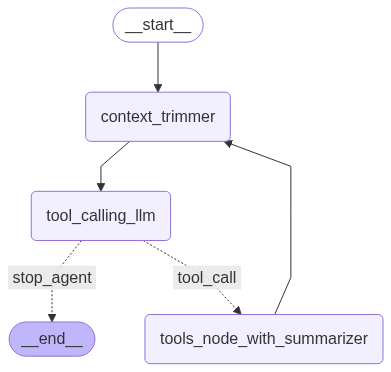

In [ ]:
agent

### Test Agent on Sample Queries

In [ ]:
uid = 'user001'
query = "Tell me latest and best methods for diabetes management"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 220
Token count (response): 23
------------------------- TOKEN USAGE -------------------------
------------------------- Summarizing Tool Results -------------------------
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 916
Token count (response): 528
------------------------- TOKEN USAGE -------------------------


Agent Final Response:



The latest methods for diabetes management in 2025 emphasize a combination of updated guidelines, innovative medications, and advanced technology. Here are the key highlights:

### 1. Updated Standards of Care
- **Source**: American Diabetes Association (ADA), December 9, 2024
- **Key Updates**:
  - **Continuous Glucose Monitors (CGMs)**: Recommended for adults with type 2 diabetes to improve glucose control.
  - **Medication Guidance**: Focus on GLP-1 receptor agonists for heart and kidney health, addressing medication shortages.
  - **Nutrition**: Emphasis on plant-based diets and increased fiber intake.
  - **Older Adults**: Specific recommendations for managing diabetes in older populations, considering social determinants of health.
  - **Complications Management**: New guidelines for screening and managing diabetes-related complications.

### 2. Top Diabetes Medications
- **Key Drugs**:
  - **GLP-1 Receptor Agonists**: Effective for weight management and blood sugar control.
  - **SGLT2 Inhibitors**: Provide heart and kidney protection.
  - **Once-Weekly Insulin**: Reduces the frequency of injections.
  - **Combination Therapies**: New GLP-1 and GIP receptor agonists show superior results.
  - **Non-Injectable Treatments**: Oral GLP-1 agonists and inhalable insulin are becoming more popular.

### 3. Technological Innovations
- **AI and Predictive Modeling**: AI tools can predict type 1 diabetes up to a year before symptoms appear, allowing for earlier intervention.
- **Patch Pumps**: Innovations like Medtronic's MiniMed Fit simplify insulin delivery.
- **Beta Cell Therapy**: Vertex's zimislecel therapy shows promise in restoring insulin-producing cells in type 1 diabetes patients.
- **Sensor Innovations**: New sensors, such as Biolinq's intradermal sensor, enhance glucose monitoring.
- **Remote Monitoring**: Programs utilizing CGMs have shown significant improvements in patient outcomes, especially in underserved populations.

### Conclusion
The integration of innovative treatments and technologies, along with a focus on personalized care, aims to enhance the quality of life for individuals living with diabetes. For more detailed information, healthcare professionals and stakeholders can refer to the full guidelines available through the ADA.

For further reading, you can check the full guidelines and updates from the ADA [here](https://www.diabetes.org/). 

### Publication Date
- **December 9, 2024** (for the ADA guidelines)

In [ ]:
query = "Please recommend a right doctor"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 1456
Token count (response): 18
------------------------- TOKEN USAGE -------------------------
------------------------- Summarizing Tool Results -------------------------
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 1565
Token count (response): 99
------------------------- TOKEN USAGE -------------------------


Agent Final Response:



I recommend the following doctor for diabetes management:

### Dr. Janet Dyne
- **Specialization**: Endocrinology (Diabetes Care)
- **Available Timings**: 10:00 AM - 1:00 PM
- **Location**: City Health Clinic
- **Contact**: [janet.dyne@healthclinic.com](mailto:janet.dyne@healthclinic.com)

You can book an appointment by emailing Dr. Dyne directly.

In [ ]:
query = "How to prevent panic attacks"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 1676
Token count (response): 23
------------------------- TOKEN USAGE -------------------------
------------------------- Summarizing Tool Results -------------------------
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 2350
Token count (response): 495
------------------------- TOKEN USAGE -------------------------


Agent Final Response:



To prevent panic attacks, it's important to understand their symptoms, causes, and effective management strategies. Here are some key approaches:

### Understanding Panic Attacks
Panic attacks are sudden episodes of intense fear that can trigger severe physical reactions. Common symptoms include:
- Rapid heart rate
- Sweating
- Trembling or shaking
- Shortness of breath
- Chest pain
- Nausea
- Dizziness
- Feelings of unreality or detachment

### Causes and Triggers
While the exact cause is not fully understood, several factors may contribute:
- **Genetics**: Family history of anxiety disorders.
- **Mental Health Conditions**: Co-occurring conditions like depression or PTSD.
- **Stressful Life Events**: Major life changes or traumatic experiences.
- **Substance Use**: Caffeine, alcohol, and certain medications.

### Immediate Coping Strategies
1. **Deep Breathing**: Focus on slow, deep breaths to calm the body.
2. **Muscle Relaxation**: Tense and then relax different muscle groups.
3. **Grounding Techniques**: Use methods like the 5-4-3-2-1 technique to focus on the present.
4. **Mindfulness**: Acknowledge the panic attack and remind yourself it is temporary.

### Long-term Strategies
- **Cognitive Behavioral Therapy (CBT)**: Helps change negative thought patterns.
- **Exposure Therapy**: Gradually exposes individuals to feared situations.
- **Medication**: Antidepressants (SSRIs, SNRIs) and anti-anxiety medications can be effective but should be used cautiously.

### Lifestyle Modifications
- Engage in regular exercise.
- Maintain a healthy diet.
- Avoid caffeine and alcohol.
- Practice stress management techniques.

### Supporting Others
If someone is experiencing a panic attack:
- Stay calm and provide reassurance.
- Encourage them to focus on their breathing.
- Help them identify and describe their physical sensations.

### When to Seek Help
Consult a healthcare provider if panic attacks are frequent or interfere with daily life. Emergency care is necessary if symptoms resemble those of a heart attack.

### Conclusion
Panic attacks can be distressing, but with proper understanding and management strategies, individuals can learn to cope effectively. Seeking professional help is essential for those experiencing recurrent panic attacks or significant anxiety.

For more detailed information, you can refer to resources from mental health organizations or consult a healthcare professional.

In [ ]:
query = "Tell me the best methods to keep my eyesight sharp"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 2862
Token count (response): 24
------------------------- TOKEN USAGE -------------------------
------------------------- Summarizing Tool Results -------------------------
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 3703
Token count (response): 461
------------------------- TOKEN USAGE -------------------------


Agent Final Response:



To keep your eyesight sharp and maintain overall eye health, consider the following best methods:

### 1. Follow the 20-20-20 Rule
- Every 20 minutes, look at something 20 feet away for 20 seconds to reduce digital eye strain.

### 2. Schedule Regular Eye Exams
- Regular check-ups are essential for early detection of conditions like glaucoma and macular degeneration.

### 3. Protect Your Eyes from UV Rays
- Wear sunglasses that block 100% of UVA and UVB rays to prevent cataracts and macular degeneration.

### 4. Fuel Your Vision with Nutrition
- Consume foods rich in omega-3 fatty acids, lutein, and vitamins C and E. Leafy greens, fish, and nuts are excellent choices.

### 5. Stay Hydrated
- Drink enough water to prevent dry eyes and maintain overall health.

### 6. Limit Blue Light Exposure
- Use blue light-blocking glasses and take breaks from screens to reduce eye strain.

### 7. Maintain Good Contact Lens Hygiene
- Wash your hands before handling lenses and follow proper cleaning schedules to prevent infections.

### 8. Stay Active for Better Circulation
- Regular exercise promotes healthy blood flow to the eyes, which is vital for maintaining vision.

### 9. Make Sleep a Priority
- Aim for 7-8 hours of quality sleep each night to support eye health.

### 10. Explore Modern Eye Care Solutions
- Consider innovative treatments for common eye issues, and stay informed about advancements in eye care.

### Eye Exercises to Improve Vision
- **Palming**: Relax your eyes by covering them with warm palms.
- **Blinking**: Regular blinking helps keep your eyes moist.
- **Pencil Push-ups**: Focus on a pencil as it moves closer to train convergence.
- **Near and Far Focus**: Alternate focus between near and distant objects.
- **Figure Eight**: Trace an imaginary figure eight to improve tracking.

### Conclusion
By incorporating these practices into your daily routine, you can take proactive steps to protect your vision and prevent potential eye problems. Regular check-ups with eye care professionals are essential for early detection and management of eye conditions. For more detailed information, consider consulting with an eye care specialist.

In [ ]:
query = "Research on the latest methods of cancer treatment"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 4166
Token count (response): 23
------------------------- TOKEN USAGE -------------------------
------------------------- Summarizing Tool Results -------------------------
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 4223
Token count (response): 568
------------------------- TOKEN USAGE -------------------------


Agent Final Response:



The latest methods of cancer treatment in 2025 showcase significant advancements in technology, precision medicine, and innovative therapies. Here are the key highlights:

### 1. Precision Medicine
- **Genomic Technologies**: Advances in Next-Generation Sequencing (NGS) are enhancing personalized cancer treatment. Tools like DeepHRD, an AI tool for detecting homologous recombination deficiency in tumors, are improving diagnostic accuracy and treatment outcomes.

### 2. Artificial Intelligence (AI)
- **AI Integration**: AI is revolutionizing cancer care by improving diagnostics, treatment planning, and optimizing clinical trials. AI tools are being integrated into clinical workflows to enhance patient outcomes and streamline processes.

### 3. Immunotherapy Advances
- **New Treatments**: Significant progress includes new immune checkpoint inhibitors and bispecific antibodies, which are showing promise in treating various cancers. The FDA has approved several new immunotherapy drugs in 2025.

### 4. Key Drug Discoveries
- **AI Drug Discovery**: A novel approach using AI has shown a 60% life extension in mouse models for colorectal cancer.
- **Combination Therapies**: New strategies combining precision drug therapy with antibodies and radiation have demonstrated effectiveness in eliminating tumors.
- **In Vivo T Cell Reprogramming**: Clinical trials are testing therapies that reprogram T cells to target multiple myeloma.
- **Quantum Computing**: Researchers are using quantum computing to identify molecules that interact with cancer-driving proteins.
- **New Cancer Vaccine**: A combination of a new vaccine and checkpoint inhibitors is showing promise in treating head and neck cancers.

### 5. Emerging Therapies
- **Thyroid Cancer**: A combination of pembrolizumab, dabrafenib, and trametinib has shown improved surgical outcomes for patients with advanced thyroid cancer.
- **Colorectal Cancer**: New combination therapies for BRAF-mutated metastatic colorectal cancer have demonstrated higher response rates and improved survival.
- **mRNA-Encoded Antibody**: A first-in-class mRNA-encoded bispecific antibody is showing promise in early trials.
- **KIF18A Inhibitor**: An oral KIF18A inhibitor is being tested for safety and efficacy in patients with chromosomal instability.
- **BPDCN Treatment**: A new antibody-drug conjugate for treating blastic plasmacytoid dendritic cell neoplasm is showing promising efficacy and safety.

### Conclusion
The advancements in oncology in 2025, particularly in precision medicine, AI integration, and immunotherapy, are set to improve patient outcomes and redefine cancer treatment paradigms. However, challenges such as access and cost remain critical issues that need to be addressed to ensure equitable cancer care for all patients.

For more detailed information, consider consulting oncology journals or healthcare professionals specializing in cancer treatment.

In [ ]:
query = "Research on common symptoms of clinical depression"
output = call_conversational_agent(agent, query, uid, verbose=False)

Running Agent. Please wait...
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 4265
Token count (response): 23
------------------------- TOKEN USAGE -------------------------
------------------------- Summarizing Tool Results -------------------------
------------------------- Trimming overall context if needed -------------------------
------------------------- TOKEN USAGE -------------------------
Token count (input context): 4815
Token count (response): 451
------------------------- TOKEN USAGE -------------------------


Agent Final Response:



Clinical depression, also known as Major Depressive Disorder (MDD), is a serious mental health condition characterized by a persistently low mood and a loss of interest in activities that were once enjoyable. Here are the common symptoms associated with clinical depression:

### Psychological Symptoms
- **Persistent Low Mood**: A continuous feeling of sadness or emptiness.
- **Feelings of Hopelessness and Helplessness**: A belief that things will not improve.
- **Low Self-Esteem and Guilt**: Excessive self-blame or feelings of worthlessness.
- **Irritability and Lack of Motivation**: Increased frustration and decreased interest in activities.
- **Difficulty Making Decisions**: Trouble concentrating or focusing.
- **Anxious or Worried Thoughts**: Persistent anxiety or worry.
- **Suicidal Thoughts**: Thoughts of death or self-harm.

### Physical Symptoms
- **Changes in Appetite or Weight**: Significant weight loss or gain, or changes in eating habits.
- **Fatigue and Low Energy**: Persistent tiredness that does not improve with rest.
- **Sleep Disturbances**: Insomnia (difficulty sleeping) or hypersomnia (sleeping too much).
- **Unexplained Aches and Pains**: Physical symptoms without a clear medical cause.

### Social Symptoms
- **Withdrawal from Social Activities**: Avoiding friends, family, and social engagements.
- **Neglecting Hobbies and Interests**: Loss of interest in activities that were once enjoyable.
- **Difficulties in Home, Work, or Family Life**: Struggles with responsibilities and relationships.

### Diagnosis and Treatment
Diagnosis is based on a thorough evaluation of symptoms, medical history, and mental health history. Treatment often involves a combination of medication (such as antidepressants) and psychotherapy (like Cognitive Behavioral Therapy).

### Conclusion
Clinical depression is a common and serious mental health condition that can significantly impact daily life. However, effective treatments are available, and early intervention can lead to better outcomes. If you or someone you know is experiencing symptoms of depression, it is important to seek help from a healthcare provider.

For more detailed information, consider consulting mental health resources or professionals specializing in depression.

We can go on running this agent and the overall context window size maintained in the agent memory is reduced by **approximately 97%**

In [ ]:
((128000-4000) / 128000) * 100 # roughly 4K tokens are in memory after multiple turns

96.875

In [ ]:
# total agent messages in the state memory at any point in time is around 16
len(agent.get_state({"configurable": {"thread_id": uid}}).values['messages'])

17